# Fourier decomposition of an image

The purpose of this notebook is to check the feasibility of using the Fourier coefficients of a TPF as a measure of how many stars there are in an image. If an algorithm can be used on the coefficients to isolate features that correlate to the number of star pixels, that will be very helpful in choosing the proportion of pixels that should go into the sky mask.

Start by importing the required modules.

In [71]:
import cv2 # pip install opencv-python
import numpy as np
from matplotlib import pyplot as plt
import os
import lightkurve as lk

LIGHTKURVE_CACHE = "/home/jtdinsmo/.lightkurve-cache/tesscut/"
COORDS = {"M34":(40.53083, 42.74615), "M7":(268.46325, -34.79283), "NGC 752":(29.421, 37.785), "IC 2391": (130.133, -53.033), 
          "NGC 6231":(253.53546, -41.82667), "Lambda Orionis":(83.784490, 9.934156), "NGC 3532":(166.44923, -58.7705),
          "Collinder 140":("111.113000", "-31.850000"),
          "Omega Cen": (201.69121, -47.47686), "47 Tuc": (6.022329, -72.081444), "NGC 6752": (287.71575, -59.98185)}
CLUSTERS = ["M34", "M7", "NGC 752", "IC 2391", "NGC 6231", "Lambda Orionis", "NGC 3532", "Collinder 140", "Omega Cen", "47 Tuc"]
LOWER_LIMIT = 10

I will run some tests to the Fourier coefficients for a few images.

/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


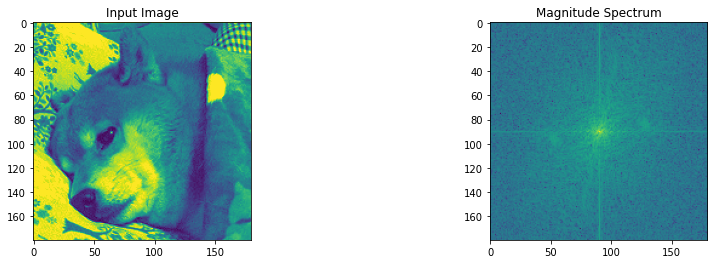

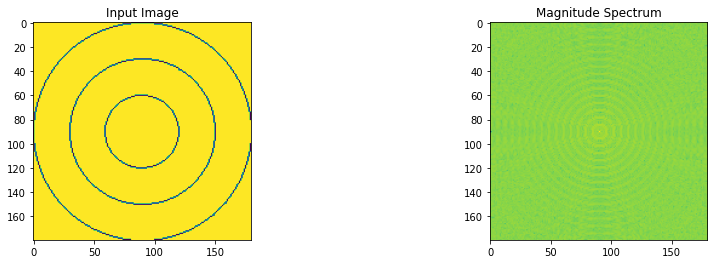

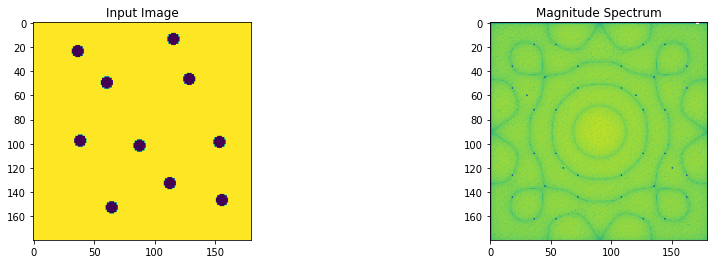

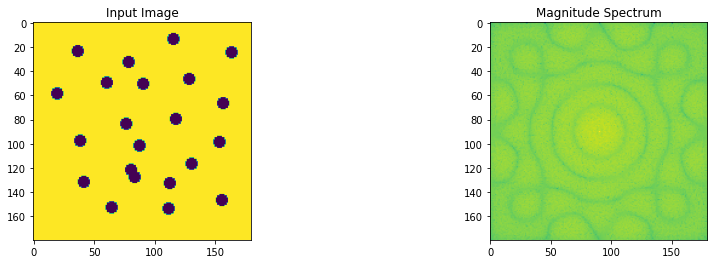

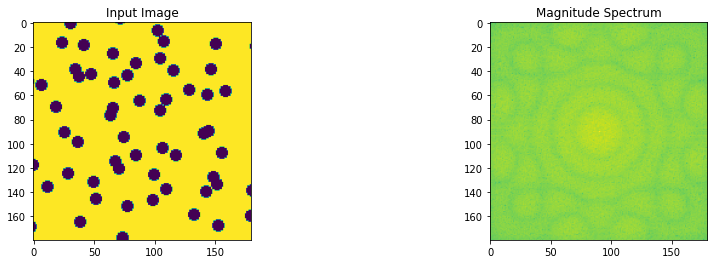

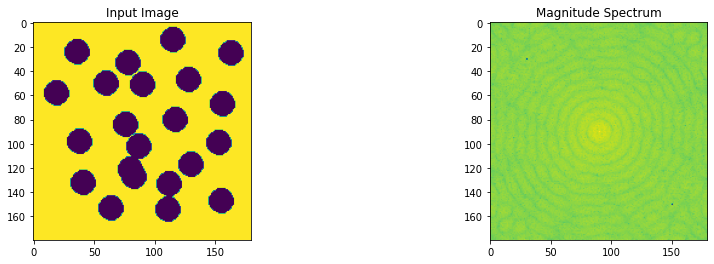

In [72]:
TESTS = ["test0.tif", "test1.tif", "test5.tif", "test2.tif",  "test4.tif", "test3.tif",]

for i in TESTS:
    img = cv2.imread(i,0)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,1]})
    ax1.imshow(img, vmax = np.nanpercentile(img, 95))
    ax1.set_title('Input Image')
    ax2.imshow(magnitude_spectrum)
    ax2.set_title('Magnitude Spectrum')

Copy over some of the code that loads the TPFs and then display their Fourier coefficients.

In [73]:
class Cluster:
    def __init__(self, name):
        self.name = name
        self.tpf = 0
        
        foundLocal = False
        for file in os.listdir(LIGHTKURVE_CACHE):
            if file.endswith("180x180_astrocut.fits"): # Confirm size
                if COORDS[name][0] == float(file.split("_")[-4]): # Confirm RA
                    if COORDS[name][1] == float(file.split("_")[-3]): # Confirm dec
                        self.tpf = lk.TessTargetPixelFile(LIGHTKURVE_CACHE + file)
                        foundLocal = True
                        break
        if not foundLocal:
            print(name + " not found")
            self.initialized = False
            return
        
        #self.image = self.tpf[self.tpf.flux.shape[0] // 2].flux.reshape((180, 180))
        self.image = np.mean(self.tpf.flux, axis=0)
        self.initialized = True
        
        # Cut out nans
        wipe = np.where(np.isnan(self.image) | (self.image < LOWER_LIMIT))
        if len(wipe[0]) == 0: return
        if wipe[1][0] == 0: # Upper left pixel should be wiped:
            minY = wipe[1][-1]
            self.image = np.delete(self.image, range(0, minY), axis=1)
        else:
            maxY = wipe[1][0]
            self.image = np.delete(self.image, range(maxY, 180), axis=1)
            
        
    def decompose(self):
        if not self.initialized: return
        f = np.fft.fft2(self.image)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20*np.log(np.abs(fshift))
        
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,1]})
        ax1.imshow(self.image, vmax = np.nanpercentile(self.image, 95))
        ax1.set_title('Input Image: ' + self.name)
        ax2.imshow(magnitude_spectrum)
        ax2.set_title('Magnitude Spectrum: ' + self.name)
        
    def decomposeBinary(self):
        if not self.initialized: return
        mid = np.nanmedian(self.image)
        binary = self.image[:]
        binary[binary <= mid] = 0
        binary[binary > mid] = 1
        if not self.initialized: return
        f = np.fft.fft2(binary)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20*np.log(np.abs(fshift))
        
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,1]})
        ax1.imshow(binary)
        ax1.set_title('Input Image: ' + self.name)
        ax2.imshow(magnitude_spectrum)
        ax2.set_title('Magnitude Spectrum: ' + self.name)

minY: 79
maxY: 65
Collinder 140 not found


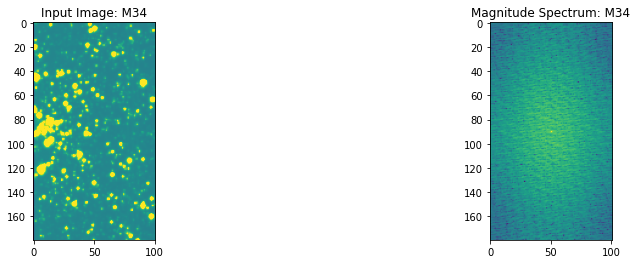

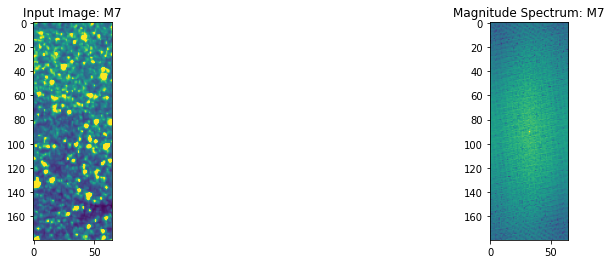

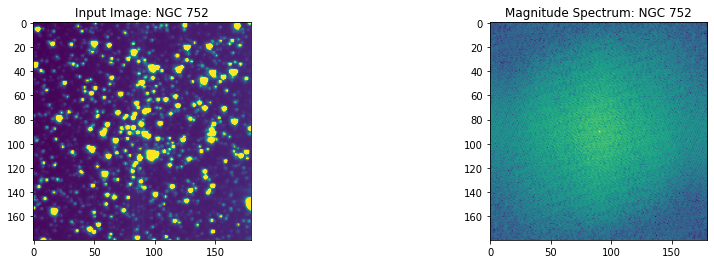

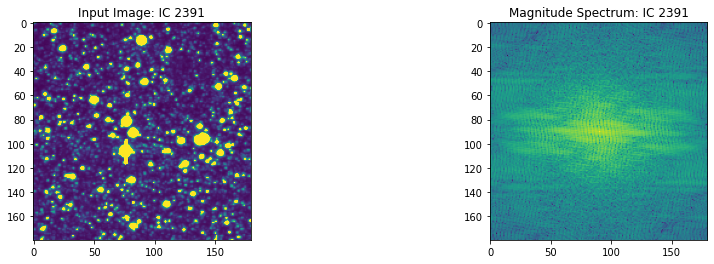

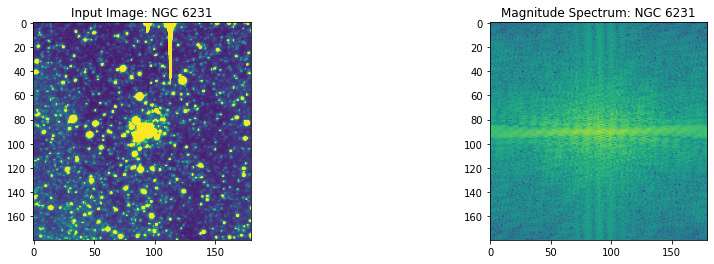

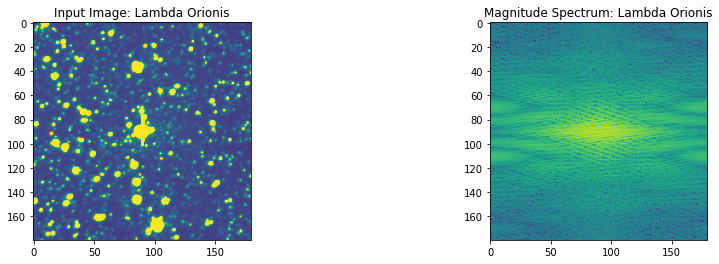

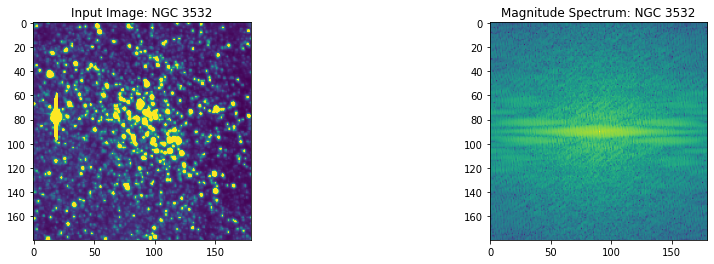

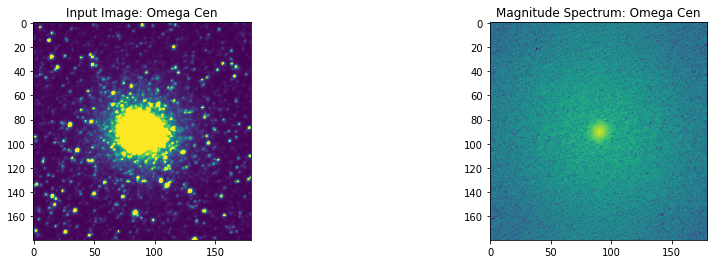

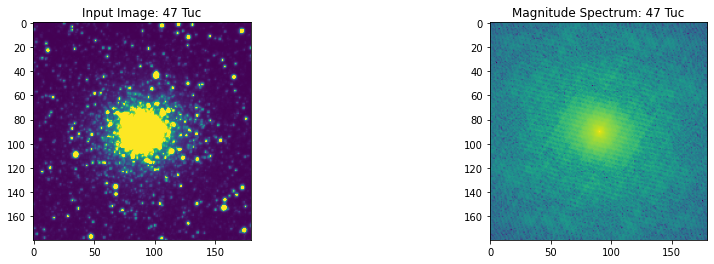

In [74]:
for name in CLUSTERS:
    c = Cluster(name)
    c.decompose()

The images appear quite blurred. What if I sharpen then by essentially rounding each pixel to one of two values?

minY: 79
maxY: 65
Collinder 140 not found


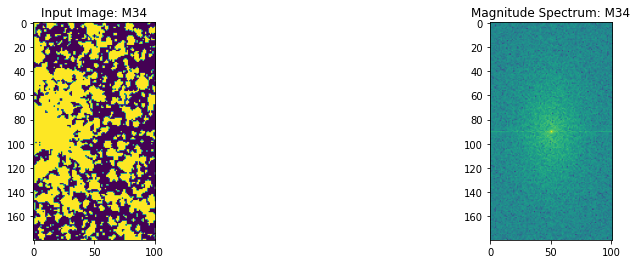

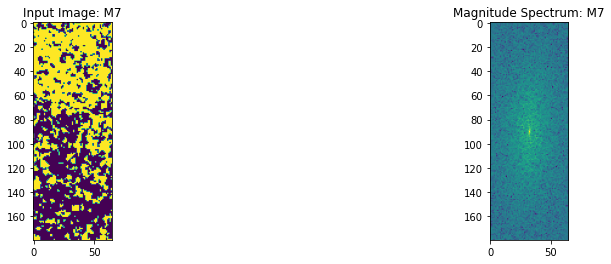

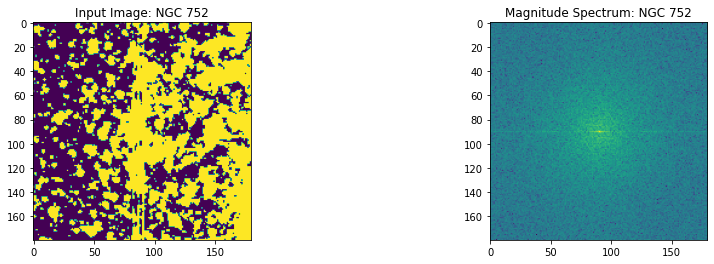

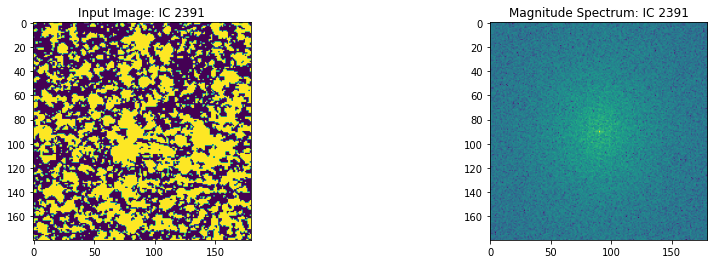

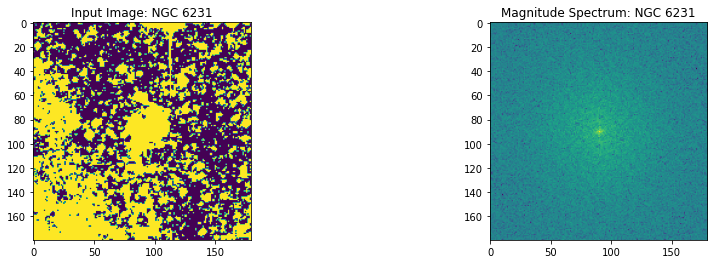

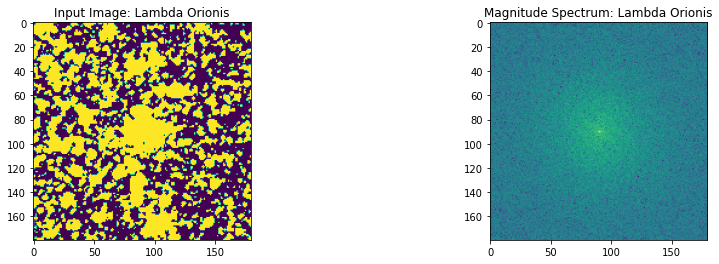

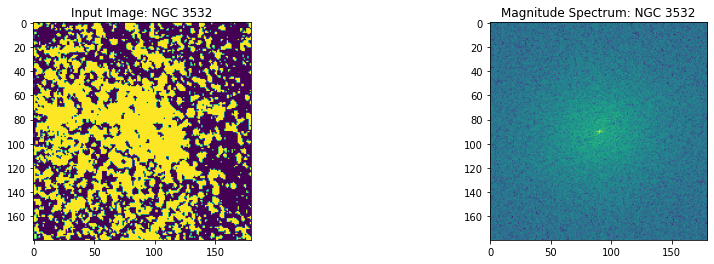

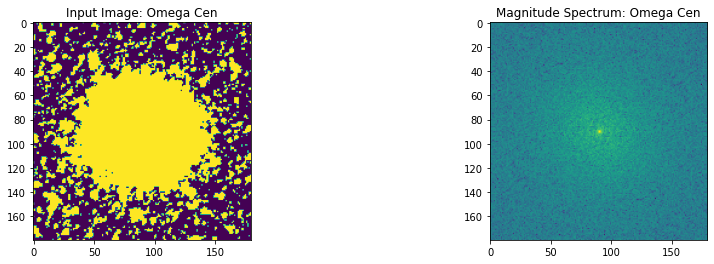

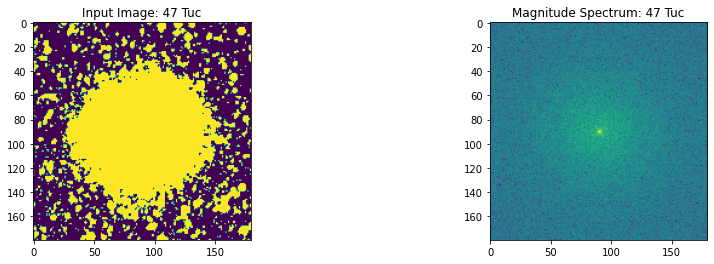

In [75]:
for name in CLUSTERS:
    c = Cluster(name)
    c.decomposeBinary()

That did not work.

#### Conclusions

The Fourier transforms do appear different, but not in a way that seems to relate to the number of stars so far as I can see. I'm not sure this would be very useful to explore.

The Fourier coefficients seem to kind of sort the clusters into classes. 

- IC 2391, Lambda Ori, NGC 3532 have a horizontal ribbon of peaks and valleys.
- M34, M7, NGC 752. A point in the middle surroinded by a diffuse cloud.
- NGC 6231. Different from all the rest, though it bears some similarities to the first category.
- Omega Cen and 47 Tuc: they have a peak of coefficients in the middle and die off radially. They are also globular clusters.

I wonder if these associations in Fourier coefficients match with physical properties of the clusters.